In [1]:
!pip install imbalanced-learn lightgbm

In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import lightgbm as lgb
import joblib
import pickle




# Step 1: Load dataset
df = pd.read_csv("/content/40k-balanced.csv")

# Step 2: Drop completely empty columns
df = df.dropna(axis=1, how='all')

# Step 3: Ensure 'loan_status' exists and drop rows where it's missing
if 'loan_status' not in df.columns:
    raise ValueError("Target column 'loan_status' not found.")
df = df.dropna(subset=['loan_status'])

# Step 4: Encode categorical features
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = df[col].astype(str)
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Step 5: Feature matrix and target vector
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 7: Impute missing values
imputer = SimpleImputer(strategy='mean')  # You can also try 'median' or 'most_frequent'
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Step 8: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Fine-tuned LightGBM model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    n_estimators=300,
    learning_rate=0.05,
    num_leaves=31,
    min_data_in_leaf=50,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=1.0,
    reg_lambda=1.0,
    random_state=42
)

model.fit(X_train_res, y_train_res)


# Step 10: Predict and evaluate
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1] if len(model.classes_) == 2 else None

print("Classification Report:\n", classification_report(y_test, y_pred))
if y_prob is not None:
    print("ROC AUC Score:", roc_auc_score(y_test, y_prob))
else:
    print("ROC AUC not available for multi-class classification.")


# Save feature columns
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003574 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3092
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No furt

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.69      0.74      4000
           1       0.73      0.83      0.78      4001

    accuracy                           0.76      8001
   macro avg       0.77      0.76      0.76      8001
weighted avg       0.77      0.76      0.76      8001

ROC AUC Score: 0.8455898525368659


['feature_columns.pkl']

In [49]:
# Save LightGBM model and imputer
joblib.dump(model, 'loan_model_lgbm.pkl')
joblib.dump(imputer, 'loan_imputer.pkl')


['loan_imputer.pkl']

In [50]:
# Load the feature column names
with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

# Take 20 random rows from real test set
sample_size = 20
base_samples = pd.DataFrame(X_test, columns=feature_columns).sample(sample_size, random_state=42)

# Create small variations to simulate new applicants
synthetic_test_cases = base_samples.copy()
variation_columns = ['loan_amnt', 'int_rate', 'dti', 'revol_util', 'installment', 'revol_bal']

for col in variation_columns:
    if col in synthetic_test_cases.columns:
        synthetic_test_cases[col] = synthetic_test_cases[col] * np.random.uniform(0.9, 1.1, size=sample_size)

# Clip only numeric columns that were varied
for col in variation_columns:
    synthetic_test_cases[col] = synthetic_test_cases[col].clip(lower=0)

# Ensure 'term' is integer and remains valid (e.g., 36 or 60)
if 'term' in synthetic_test_cases.columns:
    synthetic_test_cases['term'] = synthetic_test_cases['term'].round().astype(int)

# Display synthetic test set
synthetic_test_cases.head(20)


,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,...,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
2215,7083.881731,0,8.681462,203.497017,1.0,6.0,21034.0,6.0,0.0,55000.0,...,9.0,1.0,15814.325215,74.910116,31.0,1.0,1.0,2.0,1.0,13922.0
2582,28228.055527,1,20.440516,651.125552,3.0,18.0,6548.0,0.0,3.0,60000.0,...,16.0,0.0,32081.170013,42.257817,47.0,0.0,1.0,1.0,0.0,31836.0
1662,4134.708177,0,10.259122,139.516468,1.0,7.0,1538.0,5.0,4.0,55000.0,...,8.0,1.0,531.430658,4.052296,22.0,0.0,1.0,3.0,1.0,27660.0
3027,19345.097790,0,9.907803,587.942538,1.0,7.0,4030.0,1.0,4.0,57100.0,...,6.0,3.0,8430.449363,60.614284,10.0,1.0,1.0,0.0,0.0,24525.0
6974,22761.239390,0,6.062841,775.364679,0.0,0.0,7291.0,1.0,0.0,96000.0,...,12.0,0.0,9557.812656,31.499979,21.0,1.0,1.0,1.0,0.0,3181.0
2680,18276.201789,1,15.013622,483.266043,2.0,12.0,20974.0,3.0,4.0,85000.0,...,10.0,1.0,13308.064290,82.178373,28.0,1.0,1.0,1.0,1.0,6745.0
1765,30450.699935,1,15.867692,692.147788,3.0,18.0,4052.0,3.0,0.0,80000.0,...,9.0,0.0,23552.834006,50.566245,15.0,1.0,1.0,1.0,0.0,39890.0
1123,17544.001864,0,12.077862,555.445389,1.0,6.0,21200.0,5.0,4.0,80000.0,...,13.0,0.0,7339.111290,31.348615,17.0,0.0,1.0,0.0,0.0,1472.0
4055,10628.826330,1,20.119254,267.902794,4.0,22.0,622.0,7.0,0.0,44460.0,...,8.0,0.0,8606.243774,59.441943,13.0,0.0,1.0,2.0,0.0,29212.0
3454,7345.290221,0,9.040109,218.751850,1.0,7.0,1399.0,2.0,4.0,80000.0,...,13.0,0.0,4470.018825,13.527230,22.0,1.0,1.0,0.0,0.0,7842.0


In [53]:
# Simulated values – replace these with actual model predictions
preds = model.predict(imputer.transform(synthetic_test_cases))
probs = model.predict_proba(imputer.transform(synthetic_test_cases))[:, 1]

# Convert to human-readable predictions
prediction_labels = ['Will default' if p == 0 else "Won’t default" for p in preds]

# Create a DataFrame
results_df = pd.DataFrame({
    'Prediction': prediction_labels,
    'Default Probability': [round(p, 2) for p in probs]
})

# Display the table
results_df.head(20)

# Optional: save to CSV
# results_df.to_csv("human_readable_predictions.csv", index=False)


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,Prediction,Default Probability
0,Won’t default,0.77
1,Will default,0.24
2,Won’t default,0.90
3,Won’t default,0.73
4,Won’t default,0.86
5,Will default,0.37
6,Will default,0.40
7,Will default,0.00
8,Will default,0.00
9,Won’t default,0.83


In [54]:
# Impute and predict
X_synth = imputer.transform(synthetic_test_cases)
preds = model.predict(X_synth)
probs = model.predict_proba(X_synth)[:, 1]

# Display results
for i in range(len(preds)):
    print(f"Case {i+1}: Predicted = {preds[i]}, Default Probability = {probs[i]:.2f}")


[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
Case 1: Predicted = 1, Default Probability = 0.77
Case 2: Predicted = 0, Default Probability = 0.24
Case 3: Predicted = 1, Default Probability = 0.90
Case 4: Predicted = 1, Default Probability = 0.73
Case 5: Predicted = 1, Default Probability = 0.86
Case 6: Predicted = 0, Default Probability = 0.37
Case 7: Predicted = 0, Default Probability = 0.40
Case 8: Predicted = 0, Default Probability = 0.00
Case 9: Predicted = 0, Default Probability = 0.00
Case 10: Predicted = 1, Default Probability = 0.83
Case 11: Predicted = 0, Default Probability = 0.00
Case 12: Predicted = 1, Default Probability = 0.80
Case 13: Predicted = 1, Default Probability = 0.61
Case 14: Predicted = 0, Default Probability = 0.00
Case 15: Predicted = 0, Default Probability = 0.41


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [70]:
import pickle

with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

X_train = pd.DataFrame(X_train, columns=feature_columns)
X_test = pd.DataFrame(X_test, columns=feature_columns)


[LightGBM] [Info] Number of positive: 16000, number of negative: 16000
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004227 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3095
[LightGBM] [Info] Number of data points in the train set: 32000, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


<Figure size 1000x600 with 0 Axes>

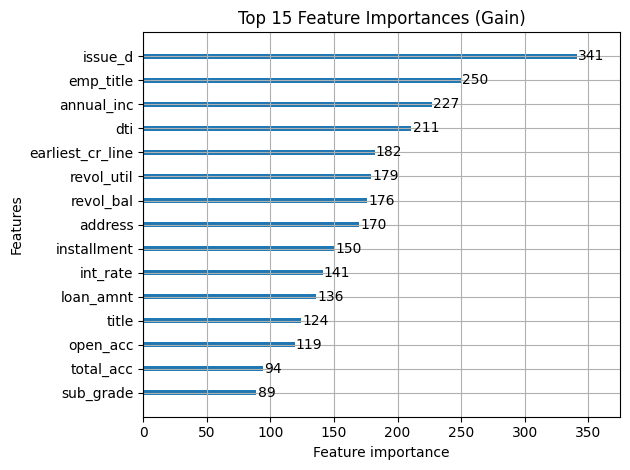

In [71]:
import pickle
import pandas as pd
import lightgbm as lgb

# Step 1: Load column names
with open('feature_columns.pkl', 'rb') as f:
    feature_columns = pickle.load(f)

# Step 2: After any preprocessing or train-test split, ensure column names are set
# Example:
X_train = pd.DataFrame(X_train, columns=feature_columns)
X_test  = pd.DataFrame(X_test, columns=feature_columns)

# Step 3: Retrain your model on DataFrame with column names
model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

# Step 4: Plot with actual feature names
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
lgb.plot_importance(model, max_num_features=15)
plt.title("Top 15 Feature Importances (Gain)")
plt.tight_layout()
plt.show()


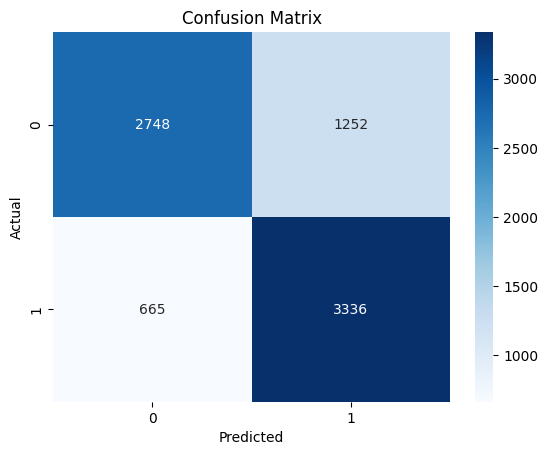

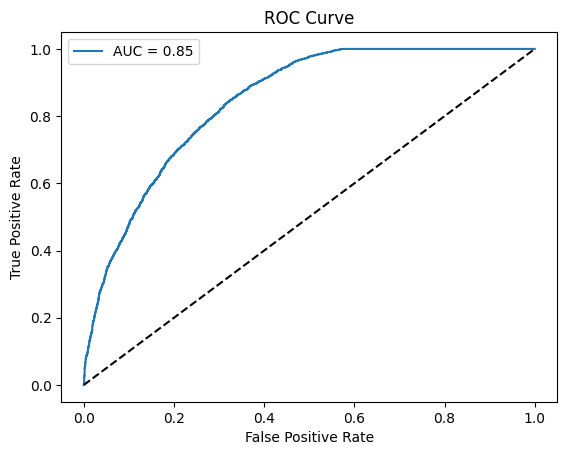

In [72]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

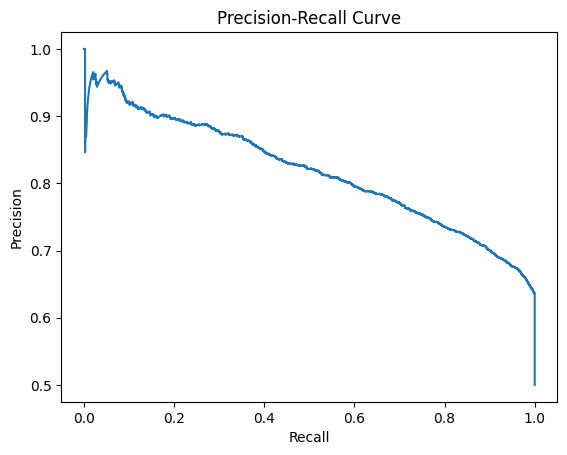

In [73]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.show()

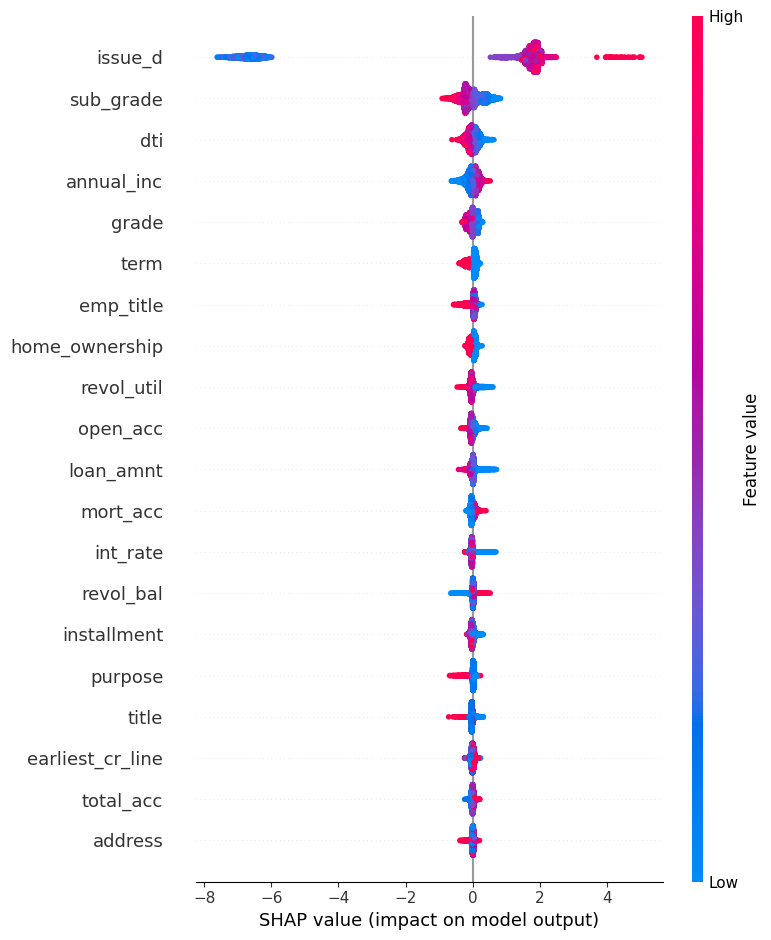

In [74]:
import shap

explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


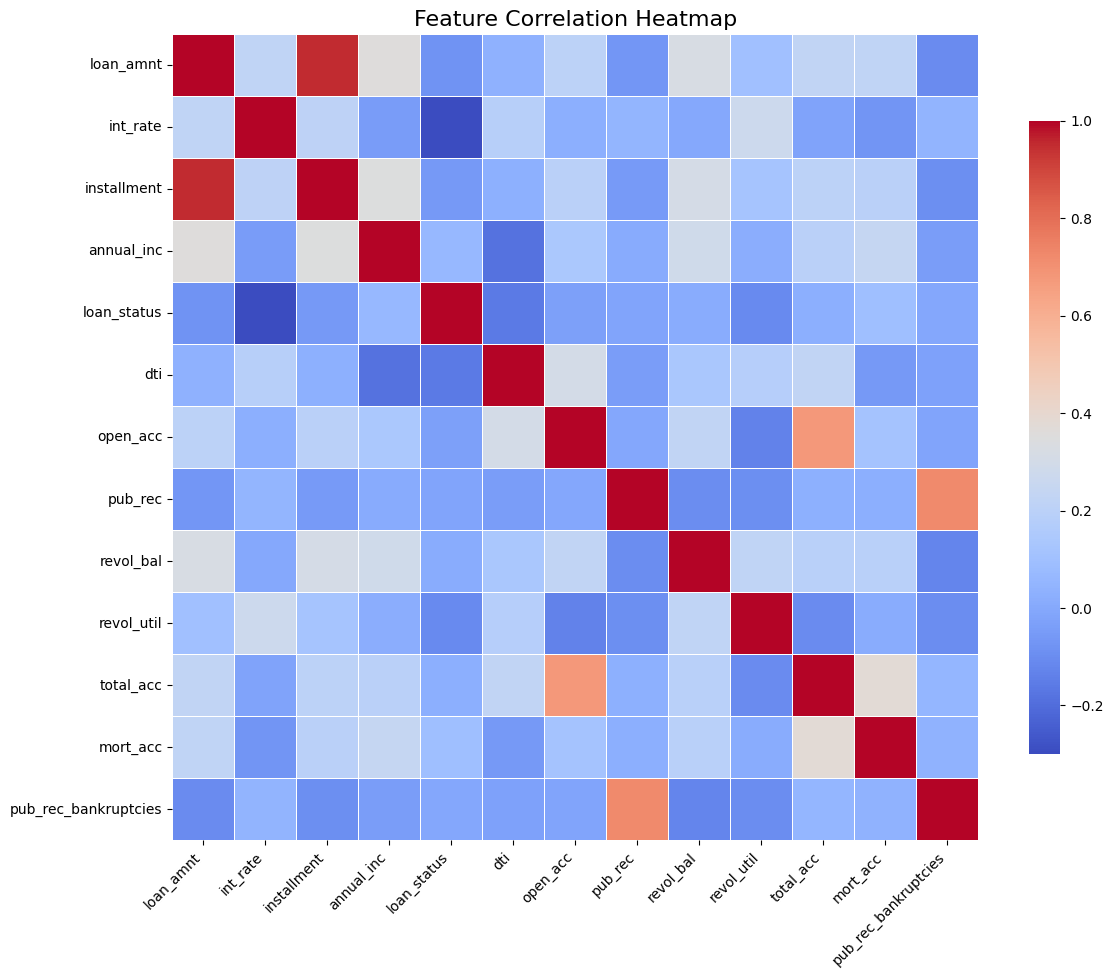

<Axes: >

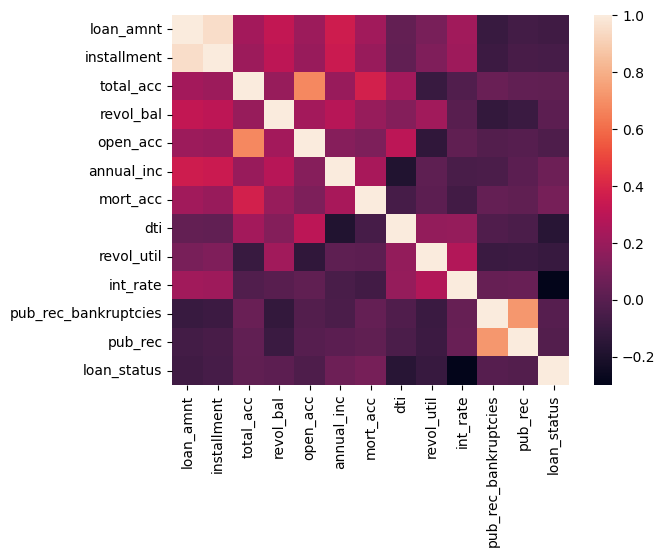

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load your dataset
df = pd.read_csv('40k-balanced.csv')  # Replace with your path

# Optional: remove non-numeric columns if needed
df_numeric = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = df_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f",
            square=True, cbar_kws={"shrink": .75}, linewidths=0.5)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

top_corr_features = corr_matrix.abs().mean().sort_values(ascending=False).head(15).index
sns.heatmap(corr_matrix.loc[top_corr_features, top_corr_features])


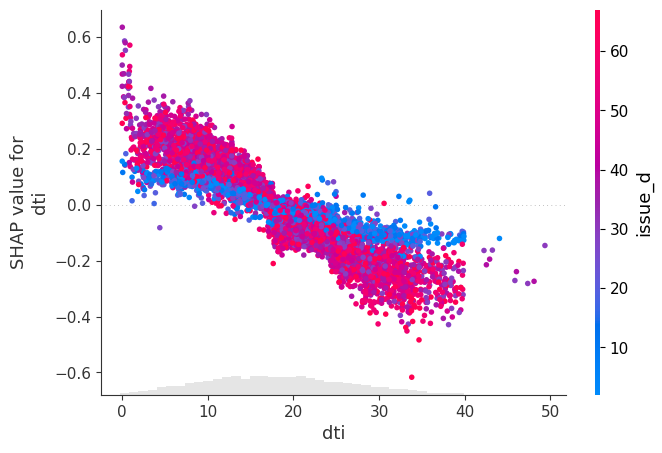

In [76]:
shap.plots.scatter(shap_values[:, "dti"], color=shap_values)